# How Multi-Task Road Extractor works ?

## Introduction

In the guide <a href="https://developers.arcgis.com/python/guide/how-unet-works/" target="_blank">How u-net works</a>, we have learned in detail about semantic segmentation using U-net in the ArcGIS API for Python. There are many other semantic segmentation algorithms like PSPNet, Deeplab, etc. which can perform road extraction. However, road network extraction from satellite images often produce fragmented road segments using only semantic segmentation algorithms, as satellite images pose difficulties in the extraction of roads due to the following reasons:

- Shadows of clouds and trees. 


- Diverse appearance and illumination conditions due to terrain, weather, geography, etc.


- The similarity of road texture with other materials.

In this guide, we explain the recent multi-task approach <a href="#References">[1]</a> to improve road connectivity in generated road masks. This work introduces a novel connectivity task called Orientation Learning, which is motivated by the human behavior of annotating roads by tracing it at a specific orientation.

<i>Note: To follow the guide below, we assume that you have some basic understanding of deep learning and convolutional neural networks (CNNs). For a detailed review of CNNs, please review Stanford University's <a href="http://cs231n.stanford.edu" target="_blank">CS231n course</a>  about Convolutional Neural Networks for Visual Recognition. Also, we recommend reading <a href="https://developers.arcgis.com/python/guide/how-unet-works/" target="_blank">How u-net works</a> before reading this one.</i>

## Multi-Task learning

Human beings attempt to find consistent patterns among our experiences and make a certain hypothesis about their features and causes. In real-life scenarios, humans do not receive tasks in isolation, but instead, receive a sequence of related tasks over time. And, humans transfer the knowledge from one scenario to another by utilizing prior experiences. 

For example, when humans learn to ride a bicycle, they will learn traffic rules, balancing the vehicle, and how and when to apply brakes. With the experience of riding a bicycle, humans can learn to ride motor-bike faster by transferring their prior knowledge/experience. In general, this ability of knowledge sharing helps humans to learn complex concepts by first learning simple concepts. Machine learning algorithms can take advantage of the human behavior of knowledge sharing to improve the performance of a complex task by learning such smaller tasks in-parallel or in-sequence.

The multi-task learning mechanism <a href="#References">[2]</a> is inspired by human beings to acquire knowledge of complex tasks by performing different shared sub-tasks simultaneously i.e. in-parallel. It improves the performance by inducing mutual information of the tasks in the learning process. In deep learning, the common architecture for multi-task learning consists of an encoder and multiple decoders to perform predictions of related tasks <i>(As shown in Figure. 1)</i>. For the road extraction system, we have one task i.e. identifying road pixels and in the next section, we will introduce the other task.

<p align="center">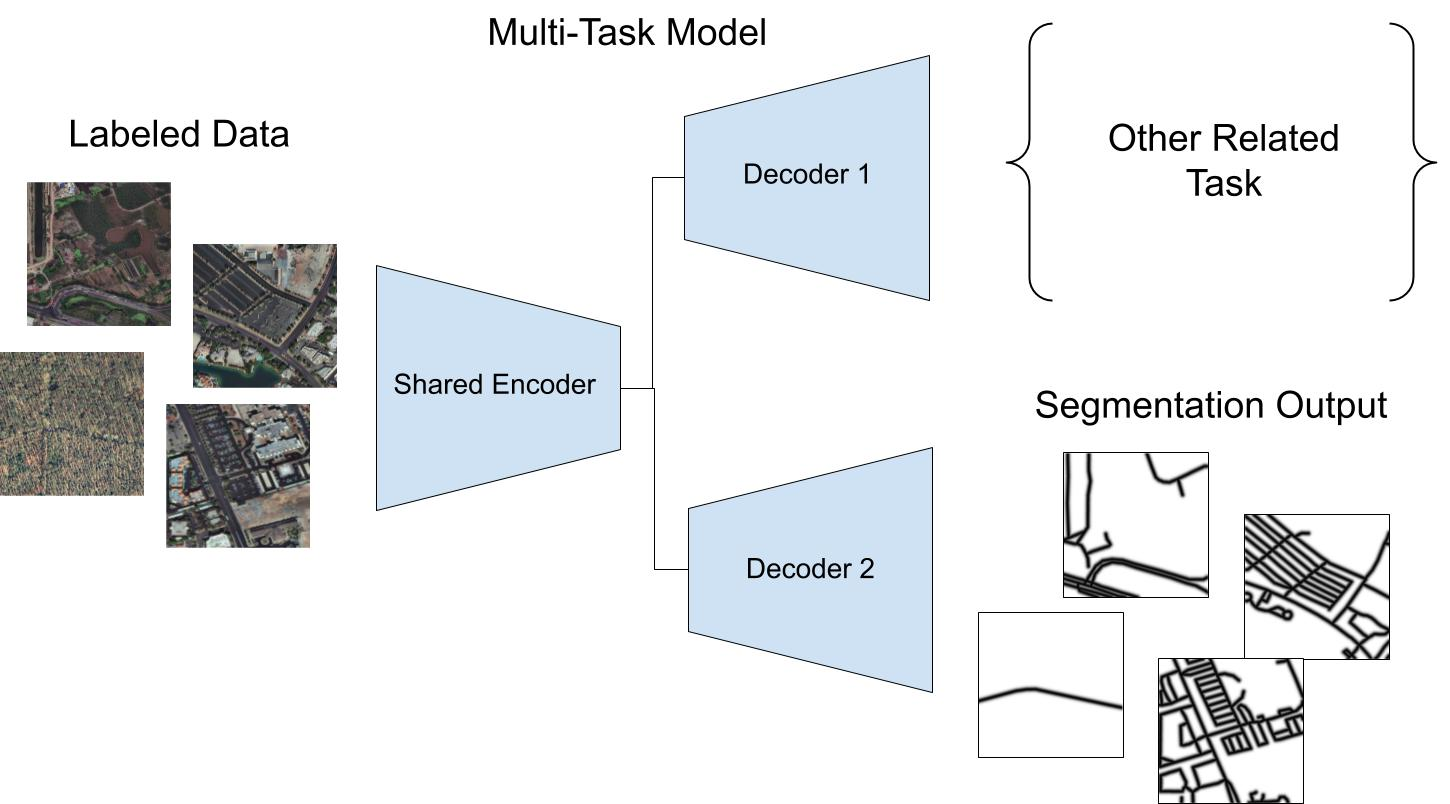</p>
<center>Figure 1: Common Multi-Task Learning framework or architecture with single encoder and multiple decoders. </center>

_**Multiple Tasks in Road Extraction:**_

Humans perform two related tasks while annotating the roads i.e. identify the road pixels and trace lines to connect them. These two tasks are used in a multi-task learning framework to improve road extraction. <i>(As shown in Figure. 2)</i>

- _Binary Semantic Segmentation:_ identify road pixels.


- _Road Orientation:_ identify the road orientation for tracing.

<p align="center">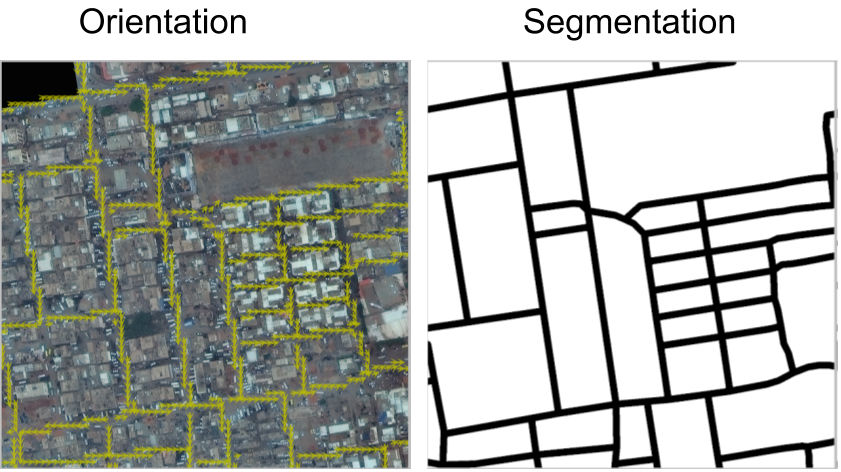</p>
<center>Figure 2: Multiple Tasks in road extraction. </center>

Road network extraction formulated as binary segmentation fails to produce a topologically correct road map due to a change in road appearance. 

As the annotators, trace lines using the highlighted nodes, <i>(As shown in Figure. 3)</i> along the center of roads with a traversable shortest path (a, c, d, e, b) for a road route a → b. The fragmented road network is estimated using binary segmentation algorithms such as PSPNet, UNet, etc. which results in the path (a, c, f, g, h, b) for the route a → b, which is not the shortest route. The annotators use additional knowledge for orientation for tracing roads to achieve this connectivity. 

Incorporating this in the Multi-Task Road Extractor framework, we extract connected and topologically correct road networks using segmentation and orientation.

<p align="center">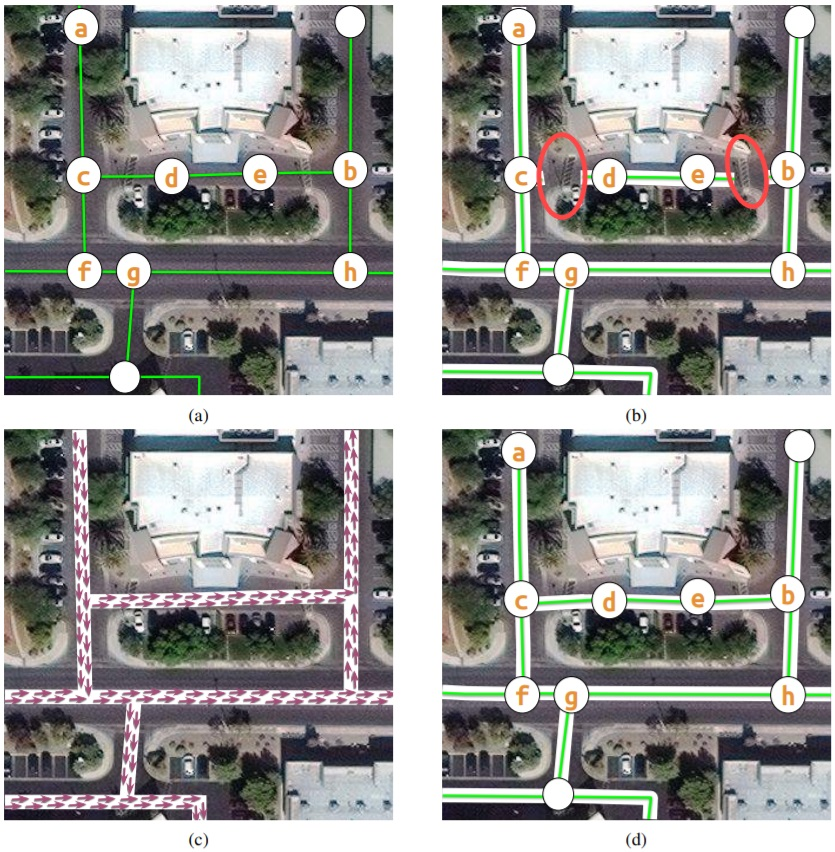</p>
<center>Figure 3: How knowledge of orientation improves road segmentation. </center>

## Model architecture

The stacked multi-branch module is composed of three blocks <i>(As shown in Figure. 4)</i>:

- _Shared encoder._


- _Stacking and Fusion:_ iterative fusion of intermediate segmentation and orientation predictions with multi-branch.



- _Prediction Heads:_ individual branches for orientation and segmentation.

<p align="center">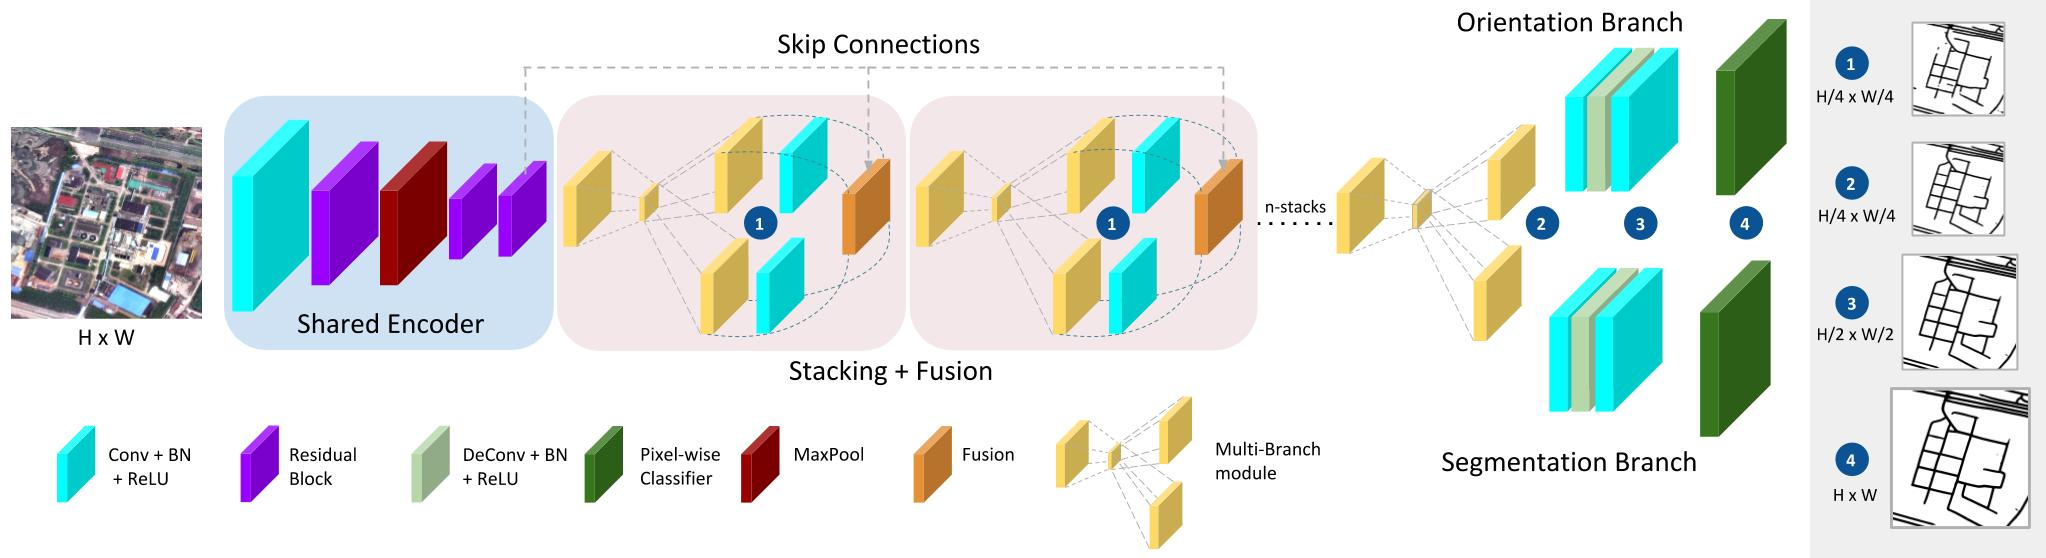</p>
<center>Figure 4: Stacked Encoder-Decoder architecture for Multi-Task Road Extractor framework. </center>

Apart from multi-task predictions, the additional feature of the architecture is the fusion of intermediate predictions at a smaller scale. The intention behind the fusion is to allow the flow of information between both tasks to improve the performance of an individual task in a multi-task learning framework <a href="#References">[1]</a>.

Advantages of the n-stack multi-branch module: 

- Large receptive field to capture the spatial context.



- Mini encoder-decoder structure learns to recalibrate features.



- Coarse predictions in a repetitive fashion.

## Implementation in `arcgis.learn`

Multi-Task Road Extractor framework in `arcgis.learn` supports two architectures, which can be set using the parameter `mtl_model`. It can be used to select one of the two supported architectures: _`linknet`_ <a href="#References">[3]</a> or _`hourglass`_<a href="#References">[1]</a>.

For exporting the data <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm" target="_blank">Export Training Data For Deep Learning</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/an-overview-of-the-image-analyst-toolbox.htm" target="_blank">Image Analyst extension</a> can be used. 






Code snippet for training:

```python
output_path = r'path/to/exported_training_chips'
data = prepare_data(output_path, chip_size=512, batch_size=4)
mtre = arcgis.learn.MultiTaskRoadExtractor(data, mtl_model="hourglass")
mtre.fit(30)
```

Where `data` is the returned data object from the `prepare_data` function. If needed, model-specific advance parameters can also be modified.

**Model-specific advance parameters are optional, as smart 'default values' are already set, which works best in most cases.**

_The advance parameters are described below:_

- `gaussian_thresh`: sets the gaussian threshold which allows setting the required road width.


- `orient_bin_size`: sets the bin size for orientation angles.


- `orient_theta`: sets the width of the orientation mask.

While backbones only work with _`linknet`_ architecture <a href="#References">[3]</a>.

After the training is completed, `mIOU()` method can be used to find how well the model is trained, `save()` method can be used to save the model.


For inferencing <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm" target="_blank">Classify Pixels Using Deep Learning</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/an-overview-of-the-image-analyst-toolbox.htm" target="_blank">Image Analyst extension</a> can be used. 

In the current implementation, certain image transforms _(Random Crop, Resize, etc.)_ are applied by default on all the training images. In the subsequent releases, the users will have an option to choose specific transforms <i>(More information about 'transforms' can be found, <a href="https://pytorch.org/vision/stable/transforms.html" target="_blank">here</a>)</i>.


For more information about the workflow, it is recommended to check out the <a href="https://developers.arcgis.com/python/api-reference/arcgis.learn.html" target="_blank">API reference</a> and <a href="https://developers.arcgis.com/python/sample-notebooks/automatic-road-extraction-using-deep-learning/" target="_blank">Automatic road extraction using deep learning</a> sample notebook.



## Setting up the environment

<i>Make sure to update your 'GPU driver' to a recent version and use 'Administrator Rights' for all the steps, written in this guide.</i>

_**Below, are the instructions to set up the required 'conda environment':**_

#### For ArcGIS Pro users:

<a href="https://github.com/esri/deep-learning-frameworks" target="_blank">Deep learning frameworks</a>
can be used to install all the required dependencies in  ArcGIS Pro's default python environment using an MSI installer. 

Alternatively,  
for a cloned environment of ArcGIS Pro's default environment, `deep-learning-essentials` metapackage can be used to install the required dependencies which can be done using the following command, in the _`Python Command Prompt`_ <i>(included with ArcGIS Pro)</i>:

`conda install -c esri deep-learning-essentials`

#### For Anaconda users (Windows and Linux platforms):

`arcgis_learn` metapackage can be used for both `windows` and `linux` installations of `Anaconda` in a new environment.

The following command will update `Anaconda` to the latest version. 

`conda update conda`

After that, metapackage can be installed using the command below:

`conda install -c esri arcgis_learn python=3.7`

_(Alternatively, 3.6 and 3.8 versions of `python` are also supported with the metapackage.)_

## References

[1] Batra, A., Singh, S., Pang, G., Basu, S., Jawahar, C. V., & Paluri, M. (2019). Improved road connectivity by joint learning of orientation and segmentation. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2019-June, 10377–10385. https://doi.org/10.1109/CVPR.2019.01063

[2] Caruana, R. A. (1993). Multitask Learning: A Knowledge-Based Source of Inductive Bias. Machine Learning Proceedings 1993, 41–48. https://doi.org/10.1016/b978-1-55860-307-3.50012-5


[3] Chaurasia, A., & Culurciello, E. (2018). LinkNet: Exploiting encoder representations for efficient semantic segmentation. 2017 IEEE Visual Communications and Image Processing, VCIP 2017, 2018-Janua, 1–4. https://doi.org/10.1109/VCIP.2017.8305148

